Descriptive Statistics for Each Category and Type (Training Data):
                             count         mean         std     min      25%  \
category type                                                                  
alcohol  injured_and_killed  252.0    20.698413   10.671308     0.0    12.75   
         total               252.0    43.753968   18.069448    10.0    30.75   
escape   injured_and_killed  252.0    44.888889   14.993078    17.0    34.00   
         total               252.0   879.428571  135.216334   411.0   793.75   
traffic  injured_and_killed  252.0   511.531746  148.671149   192.0   390.50   
         total               252.0  3537.198413  479.649632  2251.0  3205.75   

                                50%      75%     max  
category type                                         
alcohol  injured_and_killed    20.0    27.00    53.0  
         total                 40.0    53.25   107.0  
escape   injured_and_killed    43.0    55.00    85.0  
         total   

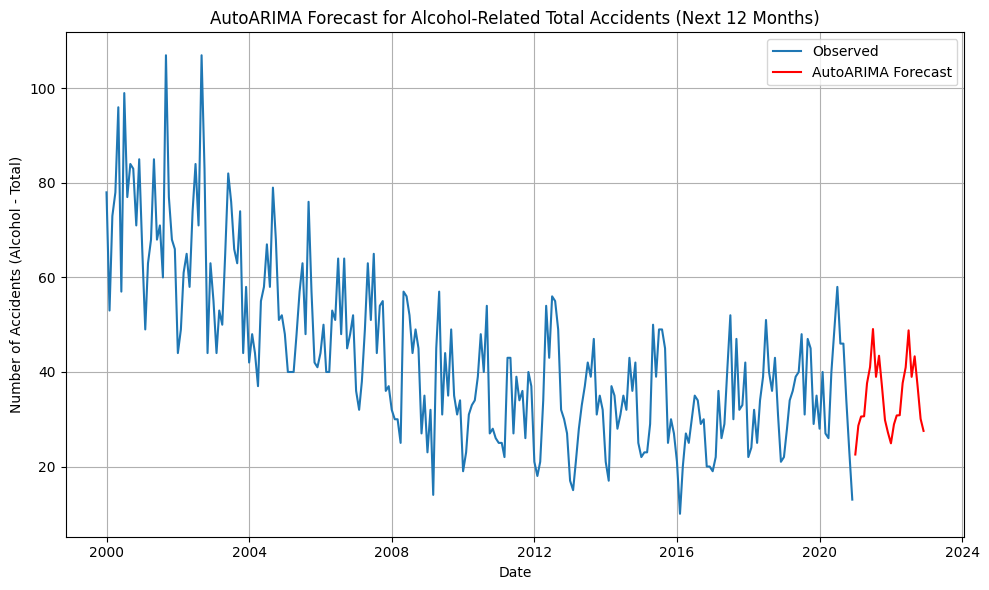

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


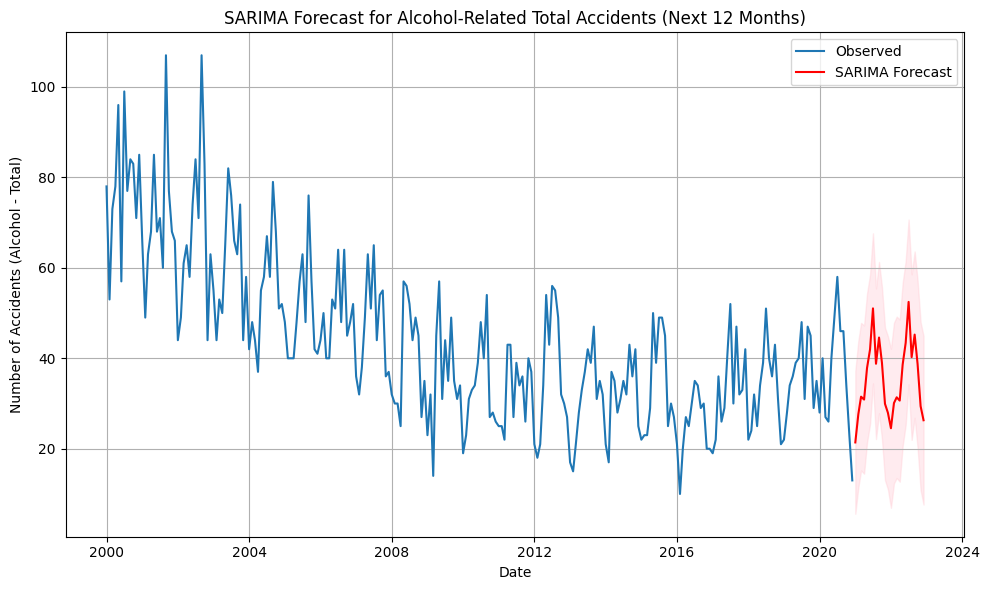

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1550 
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0427
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0340 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0215 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0183
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0213
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0202 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0187
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = 'data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv'
data = pd.read_csv(file_path, usecols=['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT'])

# Rename columns to English for easier interpretation
data.columns = ['category', 'type', 'year', 'month', 'value']

# Translate category values to English
category_map = {
    "Alkoholunfälle": "alcohol",
    "Fluchtunfälle": "escape",
    "Verkehrsunfälle": "traffic"
}
data['category'] = data['category'].map(category_map)

# Translate type values to English
type_map = {
    "insgesamt": "total",
    "Verletzte und Getötete": "injured_and_killed",
    "Verletzte": "injured"
}
data['type'] = data['type'].map(type_map)

# Remove rows where month contains 'Summe'
data = data[~data['month'].astype(str).str.contains('Summe')]

# Convert month to int
data['month'] = data['month'].astype(int)

# Extract year and month from month (yyyymm format)
data['month'] = data['month'] % 100

# Impute missing values using the mean of that month of that year
data['value'] = data.groupby(['year', 'month', 'category', 'type'])['value'].transform(lambda x: x.fillna(x.mean()))

# Drop rows where the entire month-year-category-type combination has no values
data.dropna(subset=['value'], inplace=True)

# Create a date column for easier time series handling
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

# Sort data by date to ensure proper time series ordering
data = data.sort_values(by='date')

# Split the data into training and testing sets
train_data = data[data['year'] <= 2020]
test_data = data[data['year'] > 2020]

# Descriptive statistics for each category and type
print("Descriptive Statistics for Each Category and Type (Training Data):")
print(train_data.groupby(['category', 'type'])['value'].describe())

# AutoARIMA Model (Alcohol Category - Total Type)
alcohol_total_series = train_data[(train_data['category'] == 'alcohol') & (train_data['type'] == 'total')].set_index('date')['value']

# Fit AutoARIMA model
auto_arima_model = auto_arima(alcohol_total_series, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

# Forecast for the next 12 months with AutoARIMA
auto_arima_forecast = auto_arima_model.predict(n_periods=len(test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')]))

auto_arima_forecast_index = test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')].set_index('date').index[:len(auto_arima_forecast)]

# Plot AutoARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(alcohol_total_series, label='Observed')
plt.plot(auto_arima_forecast_index, auto_arima_forecast, color='r', label='AutoARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Alcohol - Total)')
plt.title('AutoARIMA Forecast for Alcohol-Related Total Accidents (Next 12 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SARIMA Model for alcohol category with type total
# Fit SARIMA model
sarima_model = SARIMAX(alcohol_total_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

# Forecast for the next 12 months with SARIMA
sarima_forecast = sarima_result.get_forecast(steps=len(test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')]))
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot SARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(alcohol_total_series, label='Observed')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean, color='r', label='SARIMA Forecast')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Alcohol - Total)')
plt.title('SARIMA Forecast for Alcohol-Related Total Accidents (Next 12 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM Model Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(alcohol_total_series.values.reshape(-1, 1))

# Create sequences for LSTM
sequence_length = 12
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length])
    y.append(scaled_data[i + sequence_length])
X, y = np.array(X), np.array(y)

# Split into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
lstm_model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions for the next few months
lstm_predictions = []
input_sequence = X_test[-1]  # Start with the last sequence from the test set

for _ in range(len(test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')])):  # Predict for test set length
    next_value = lstm_model.predict(input_sequence.reshape(1, sequence_length, 1))
    lstm_predictions.append(next_value[0, 0])
    input_sequence = np.append(input_sequence[1:], next_value, axis=0)

# Rescale the LSTM predictions back to original scale
lstm_predictions_rescaled = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))

Mean Squared Error (MSE) for AutoARIMA model: 91.64418863740813
Mean Squared Error (MSE) for SARIMA model: 80.32572856907296
Mean Squared Error (MSE) for LSTM model: 192.26708452924808
Mean Absolute Error (MAE) for AutoARIMA model: 8.15806019607175
Mean Absolute Error (MAE) for SARIMA model: 7.565284465090819
Mean Absolute Error (MAE) for LSTM model: 11.600969314575195


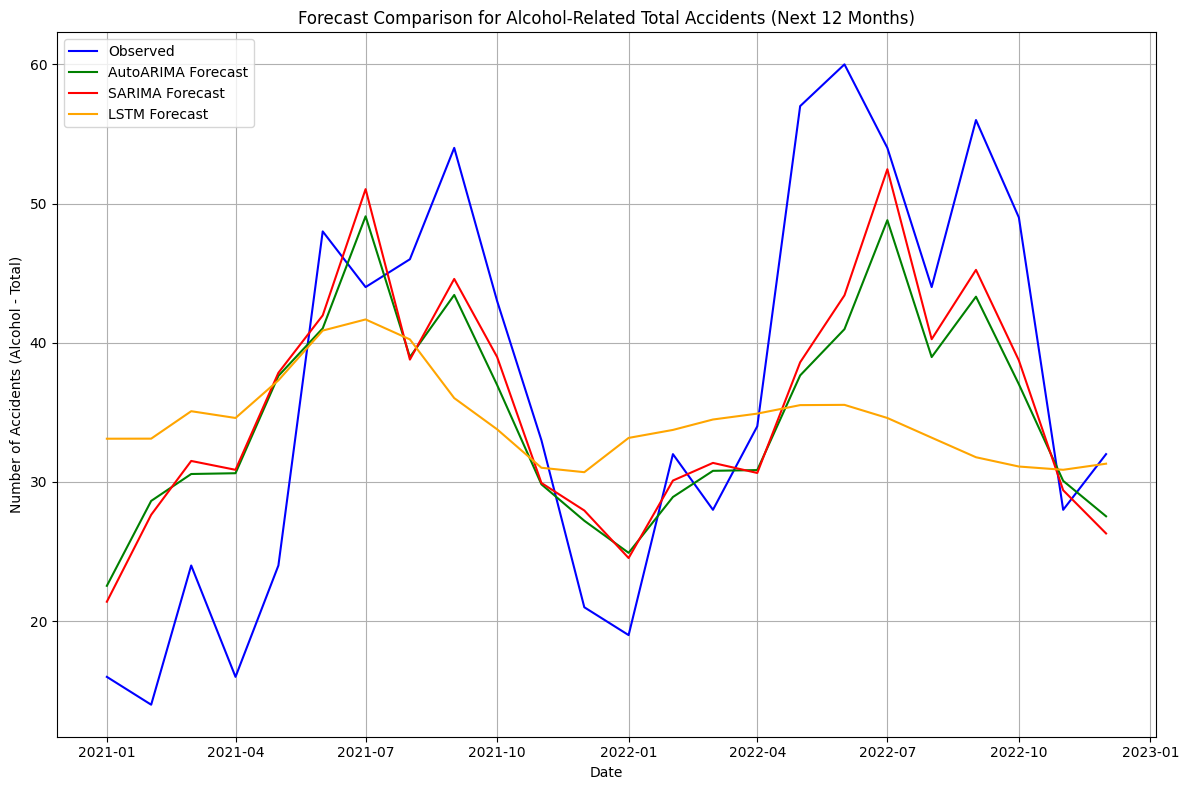

In [24]:
# Calculate metrics for AutoARIMA, SARIMA, and LSTM models
# Align forecast and test data
test_alcohol_total_series = test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')].set_index('date')['value']
test_forecast_values_arima = auto_arima_forecast[:len(test_alcohol_total_series)]
test_forecast_values_sarima = sarima_forecast_mean[:len(test_alcohol_total_series)]
test_forecast_values_lstm = lstm_predictions_rescaled.flatten()[:len(test_alcohol_total_series)]

# Calculate metrics
mse_arima = mean_squared_error(test_alcohol_total_series, test_forecast_values_arima)
mse_sarima = mean_squared_error(test_alcohol_total_series, test_forecast_values_sarima)
mse_lstm = mean_squared_error(test_alcohol_total_series, test_forecast_values_lstm)

mae_arima = mean_absolute_error(test_alcohol_total_series, test_forecast_values_arima)
mae_sarima = mean_absolute_error(test_alcohol_total_series, test_forecast_values_sarima)
mae_lstm = mean_absolute_error(test_alcohol_total_series, test_forecast_values_lstm)

print(f'Mean Squared Error (MSE) for AutoARIMA model: {mse_arima}')
print(f'Mean Squared Error (MSE) for SARIMA model: {mse_sarima}')
print(f'Mean Squared Error (MSE) for LSTM model: {mse_lstm}')

print(f'Mean Absolute Error (MAE) for AutoARIMA model: {mae_arima}')
print(f'Mean Absolute Error (MAE) for SARIMA model: {mae_sarima}')
print(f'Mean Absolute Error (MAE) for LSTM model: {mae_lstm}')

# Plot all predictions
plt.figure(figsize=(12, 8))
plt.plot(test_alcohol_total_series.index, test_alcohol_total_series, label='Observed', color='blue')
plt.plot(auto_arima_forecast_index, test_forecast_values_arima, label='AutoARIMA Forecast', color='green')
plt.plot(test_forecast_values_sarima.index, test_forecast_values_sarima, label='SARIMA Forecast', color='red')
plt.plot(test_alcohol_total_series.index, test_forecast_values_lstm, label='LSTM Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Alcohol - Total)')
plt.title('Forecast Comparison for Alcohol-Related Total Accidents (Next 12 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SARIMA Model outperforms all other models in terms of MSE and MAE. We will use SARIMA model for forecasting.